# Redoing the drone CEA from Maaz 2024

In [1]:
from markovag import markov
from markovag import cad
from sympy import Symbol, solve, Interval, oo, Number, simplify, S
from sympy.matrices import Matrix, eye, zeros, ones, diag
from sympy.plotting.plot import PlotGrid
import pandas as pd
import numpy as np
import seaborn as sns


In [2]:
# utility
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

## Reading data and modelling

The patient table below is an anonymized and "noisified" version of the original patient table to ensure data privacy. Noise was added to the data set by flipping binary/categorical columns with a certain probability, and adding Gaussian noise to continuous columns. Then, additional constraints were applied, for example v2egimrs==nan if and only if pdisp==0, and the p_mrs columns should add up to 1. Therefore, the results in this notebook are not an exact match of the results presented in the paper, but are quite similar.

In [3]:
df = pd.read_csv('drones_files/patient_table.csv')

df

,pdisp,v2egimrs,p_used,p_shock,p_gotohosp,p_mrs.1,p_mrs.2,p_mrs.3,p_mrs.4,p_mrs.5,p_mrs.6,p_mrs.7
0,0,NaN,0.000,0.357856,0.581051,0.014667,0.000000,0.000000,0.028240,0.000000,0.000000,0.957093
1,0,NaN,0.000,0.143290,1.000000,0.000000,0.000000,0.071402,0.054062,0.035736,0.000000,0.838799
2,0,NaN,0.457,0.151453,0.414185,0.000000,0.027795,0.108711,0.000000,0.004423,0.000000,0.859071
3,0,NaN,0.457,0.372155,0.610286,0.028817,0.010485,0.017279,0.009212,0.000000,0.004176,0.930031
4,0,NaN,0.457,0.208349,0.531964,0.040057,0.052110,0.000000,0.031787,0.000000,0.035184,0.840862
...,...,...,...,...,...,...,...,...,...,...,...,...
22012,0,NaN,0.000,0.087020,0.446446,0.000607,0.021613,0.081403,0.000000,0.000000,0.000000,0.896376
22013,0,NaN,0.000,1.000000,0.839605,0.020927,0.010723,0.000000,0.029825,0.070830,0.004923,0.862771
22014,1,0.0,0.457,0.426876,0.664653,0.109773,0.053132,0.041895,0.000000,0.000000,0.000000,0.795199
22015,1,6.0,0.457,1.000000,1.000000,0.000000,0.000000,0.056777,0.000000,0.004662,0.000000,0.938561


Each patient has the following data
- pdisp: whether they died in reality
- v2egimrs: if they survived, what was their MRS? in reality
- p_used: 0 if drone does not beat the ambulance by more than 90s, non-zero p_use otherwise
- p_shock: probability of shockable rhythm, given by ML model
- p_gotohosp: probability that they survived to hospital, given by ML model
- p_mrs.i (i from 1 to 7, representing MRS=i-1): the predicted MRS

In this analysis, we have the same Markov chains in both the drone case and the base case, the only difference is the initial vectors. The states in the Markov chains are dis_0, first_0, later_0, dis_1, first_1, later_1, ... up to dis_6, death. Let $\tilde{u}$ be a vector of the total infinite horizon utility assuming you start at some state in this chain. Let $\tilde{c}$ be a vector of the total infinite cost assuming you start at some state. 

We know that $\tilde{u} = (I - \lambda P)^{-1} u$ and $\tilde{c} = (I - \lambda P)^{-1} c$.

In the base case, each person's initial distribution vector is a corner of the probability simplex: either the 1 is in death if `pdisp==1` or the 1 is in the discharge state of their MRS according to data. So, for each statement, each of these vectors will be multiplied (dot product) with $\tilde{u}$ and $\tilde{c}$. Then, we have to sum over all patients, so by factoring, we can just count how many patients are in each state. Define $n_{dis0}^b$, $n_{dis1}^b$, ... $n_{dis6}^b$, and $n_{death}^b$ be the number of patients discharged at the indicated MRS, or death, in the base case (b), form a vector of these that aligns with the states, and then take the dot product. 

Similarly, in the drone case, for each patient, let $\textbf{p}_{pred}$ be the predicted probabilities outputted by the ML model. Again, we expand the vector to align with the states, and then take the dot product. However, we then scale this by $p_{used} \times p_{hosp}$, where the latter is given by the ML model, but $p_{used}$ can be free. If the drone is used but the patient does not go to hospital, then both utilities and costs are 0. Lastly, if the drone is not used, which happens with probability $1 - p_{used}$, then we revert to the base case. Recall that we calculated the base case cost and utilities by taking the dot product of a vector with a single $1$ and the rest zereos with $\tilde{u}$ or $\tilde{c}$. Now, in this case, that $1$ gets multiplied by $1-p_{used}$ for each patient. So, we can instead sum $1-p_{used}$ for patients with the same base case status in order to fill in the entries of a final vector, with which we dot product with $\tilde{u}$ or $\tilde{c}$.

Mathematically,
- let $v_{base}$ be the vector containing base case counts:
    - In the index corresponding to discharge with MRS $i$, it contains the counts of patients discharged with MRS $i$ based on historical data
    - In the index corresponding to death, it contains the counts of patients who died before reaching hospital.
    - All other entries are $0$.
- let $v_{pred}$ be the vector containing the sums of predicted MRS across patients:
    - In the index corresponding to discharge with MRS $i$, it contains probability of being discharged with MRS $i$, times that patient's $p_{used} \times p_{hosp}$, then summed over all patients
    - All other entries are $0$.
- let $v_{revert}$ be the vector pertaining to the case where we revert to the base case:
    - In the index corresponding to discharge with MRS $i$ or death, it contains $1 - p_{used}$, summed over all patients discharged with MRS $i$ or death based on historical data.

In [33]:
p_use = Symbol('p_u')

In [34]:
# computes the vectors from the description above

v_base = [0] * 20 # there are 20 states in total
v_pred = [0] * 20
v_revert = [0] * 20
for index, row in df.iterrows():
    # check base case
    if row['pdisp'] == 0:
        v_base[-1] += 1
    else:
        v_base[int(3*row['v2egimrs'])] += 1 # super hacky way to map indices but its ok...

    # check preds
    this_p_use = 0 if row['p_used'] == 0 else p_use

    for i in range(1, 7+1):
        v_pred[3*(i-1)] += row[f'p_mrs.{i}'] * row['p_gotohosp'] * this_p_use

    # check reverts
    if row['pdisp'] == 0:
        v_revert[-1] += 1 - this_p_use
    else:
        v_revert[int(3*row['v2egimrs'])] += 1 - this_p_use



In [35]:
v_base = Matrix(v_base)
v_pred = Matrix(v_pred)
v_revert = Matrix(v_revert)

In [36]:
# these are the empirical values

P_emp = markov.parse_matrix(file='drones_files/drone_probs.csv', ignore_header=True, ignore_rownames=True)
utils_emp = markov.parse_matrix(file='drones_files/drone_utils.csv', ignore_header=True)
costs_emp = markov.parse_matrix(file='drones_files/drone_costs.csv', ignore_header=True)

There is some special structure to the probability transition matrix, the cost vector, and the utility vector.

In the probability transition matrix, the discharge states are tunnel states that always go to the corresponding 'first' state. When in the 'first' state, the patient either dies or goes to the 'later' state; in the 'later' state, the patient either dies or stays in the 'later' state. When discharged with MRS 6, the patient goes to death with probability 1, and of course if in death stays in death.

In the utilities vector, we assume that the 'first' and 'later' of the same MRS have the same utility, the discharge states have no utility (they are just there to capture the costs), and death has no utility.

In the costs vector, every state has a non-zero cost, except for death which has a zero cost.

Given these, we have the following _symbolic_ versions of our Markov primitives.

In [37]:
P_mod = markov.parse_matrix(file='drones_files/drone_probs_mod.csv', ignore_header=True, ignore_rownames=True)
utils_mod = markov.parse_matrix(file='drones_files/drone_utils_mod.csv', ignore_header=True)
costs_mod = markov.parse_matrix(file='drones_files/drone_costs_mod.csv', ignore_header=True)

Now we are ready to compute the base costs, base utils, drone costs, and drone utils.

In [38]:
nmb_base = markov.infinite_horizon_reward(P_mod, v_base, 150000 * utils_mod - costs_mod, 0.97)
nmb_drone = markov.infinite_horizon_reward(P_mod, v_pred + v_revert, 150000 * utils_mod - costs_mod, 0.97)
opcost_drone = Symbol('m') * (154000 * 20 + 275 * 22017) # 154000 times #drones + 275 times #pt

ineq = nmb_drone[0] * nmb_base[1] - nmb_base[0] * nmb_drone[1] - opcost_drone * nmb_drone[1] * nmb_base[1] >= 0
ineq = simplify(ineq.lhs.expand()) >= 0

In [39]:
ineq

-1.20407807736752e-9*m - 1.17698246471857e-7*p_0*p_u + 1.86520412624192e-7*p_u >= 0

In [40]:
# just scaling for readability
ineq = ineq.lhs * S(10)**(9) >= 0

display(round_expr(ineq, 3))

-1.204*m - 117.698*p_0*p_u + 186.52*p_u >= 0

## Sensitivity analysis

### CAD

In [41]:
p_0 = Symbol('p_0')
m = Symbol('m')
p_use = Symbol('p_u')

In [42]:
simplex = cad.glue_simplex_cads([cad.simplex_cad([p_use], sub=True), cad.simplex_cad([p_0], sub=True)])
gs = cad.make_g_functions(ineq.lhs, [m])
simplex = cad.simplex_extensible_cad(simplex, gs[0], gs[1:], [m])

In [43]:
cad.cad_print(simplex)

root
├──  $p_u = 0$
│   ├──  $p_0 = 0$
│   │   └──  $m = 0$
│   ├──  $0 < p_0 < 1$
│   │   └──  $m = 0$
│   └──  $p_0 = 1$
│       └──  $m = 0$
├──  $0 < p_u < 1$
│   ├──  $p_0 = 0$
│   │   ├──  $m = 0$
│   │   ├──  $0 < m < 154.907240759654 p_{u}$
│   │   └──  $m = 154.907240759654 p_{u}$
│   ├──  $0 < p_0 < 1$
│   │   ├──  $m = 0$
│   │   ├──  $0 < m < - 97.7496797626127 p_{0} p_{u} + 154.907240759654 p_{u}$
│   │   └──  $m = - 97.7496797626127 p_{0} p_{u} + 154.907240759654 p_{u}$
│   └──  $p_0 = 1$
│       ├──  $m = 0$
│       ├──  $0 < m < 57.1575609970416 p_{u}$
│       └──  $m = 57.1575609970416 p_{u}$
└──  $p_u = 1$
    ├──  $p_0 = 0$
    │   ├──  $m = 0$
    │   ├──  $0 < m < 154.907240759654$
    │   └──  $m = 154.907240759654$
    ├──  $0 < p_0 < 1$
    │   ├──  $m = 0$
    │   ├──  $0 < m < 154.907240759654 - 97.7496797626127 p_{0}$
    │   └──  $m = 154.907240759654 - 97.7496797626127 p_{0}$
    └──  $p_0 = 1$
        ├──  $m = 0$
        ├──  $0 < m < 57.1575609970416$
  

### 3-way

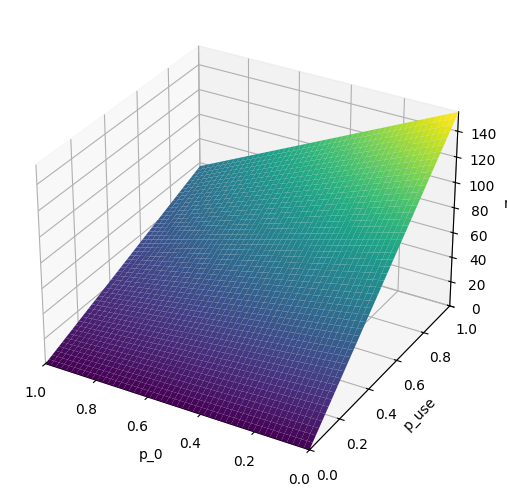

In [44]:
markov.plot_simple(ineq, nvar=3, plottype='boundary', z_var=m, y_var=(p_use,0,1), x_var=(p_0,1,0), ylabel="p_use", xlabel="p_0", zlabel="m", margin=0, size=(5, 5))

### Two way

In [45]:
gray = "#C1CAD6"
red = "#CD4631"
green = "#04A777"

In [46]:
# classic mesh grid way
valid_points = []
invalid_points = []
for p_0_curr in np.linspace(0, 1, 10):
    for p_use_curr in np.linspace(0, 1, 10):
        if ineq.subs({m:10, p_0:p_0_curr, p_use:p_use_curr}) == True:
            valid_points.append([p_0_curr, p_use_curr])
        else:
            invalid_points.append([p_0_curr, p_use_curr])

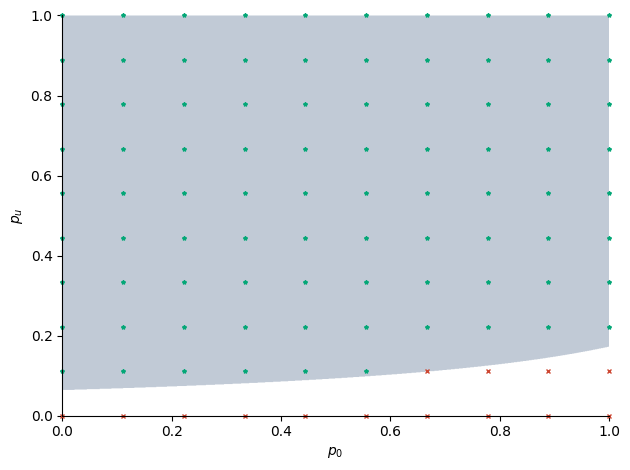

In [47]:
plt = markov.plot_simple(ineq.subs({m:10}), plottype='region', x_var=(p_0, 0, 1), y_var=(p_use, 0, 1), line_color="#C1CAD6", alpha=0.5, axis_center=(0,0),
                         markers=[{'args': [[v[0] for v in valid_points], [v[1] for v in valid_points], '*'], 'color': "#04A777", "ms": 3, "clip_on":False},
                                  {'args': [[v[0] for v in invalid_points], [v[1] for v in invalid_points], 'x'], 'color': "#CD4631", "ms": 3, "clip_on":False}])

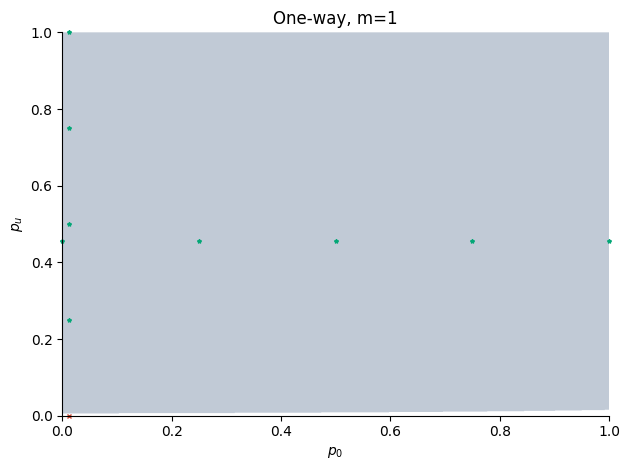

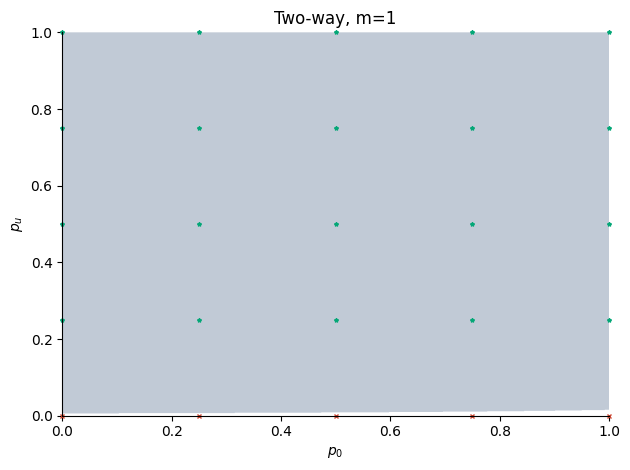

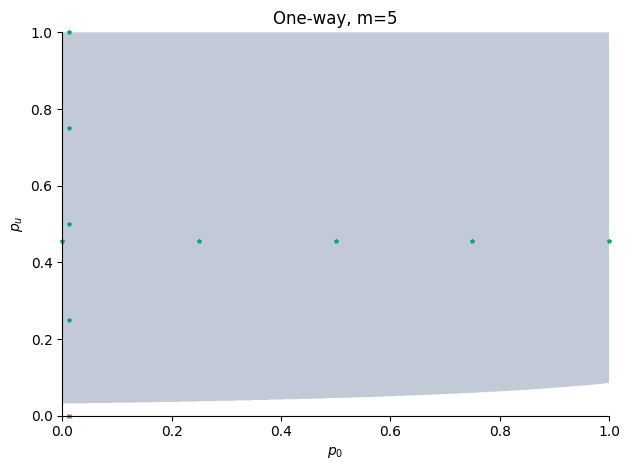

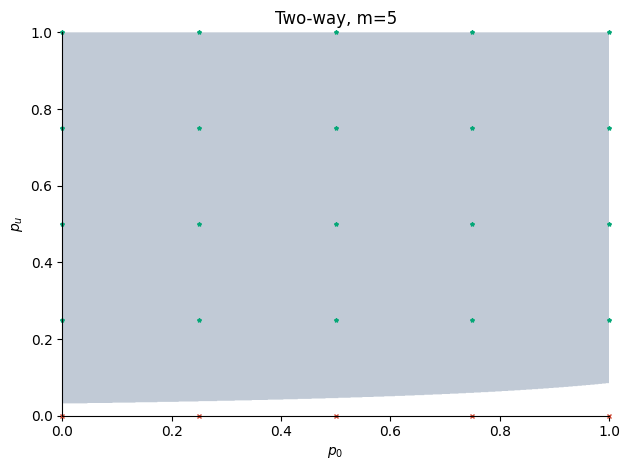

In [48]:
plots = []
for m_curr in [1, 5]:
    # one way sens analysis
    # set p_use at 0.457, p_0 at 0.013
    mesh_size = 5
    valid_points = []
    invalid_points = []
    # fix p_0
    p_0_curr = 0.013
    for p_use_curr in np.linspace(0, 1, mesh_size):
        if ineq.subs({m:m_curr, p_0:p_0_curr, p_use:p_use_curr}) == True:
            valid_points.append([p_0_curr, p_use_curr])
        else:
            invalid_points.append([p_0_curr, p_use_curr])
    # fix p_use
    p_use_curr = 0.457
    for p_0_curr in np.linspace(0, 1, mesh_size):
        if ineq.subs({m:m_curr, p_0:p_0_curr, p_use:p_use_curr}) == True:
            valid_points.append([p_0_curr, p_use_curr])
        else:
            invalid_points.append([p_0_curr, p_use_curr])

    plot = markov.plot_simple(ineq.subs({m:m_curr}), plottype='region', x_var=(p_0, 0, 1), y_var=(p_use, 0, 1), line_color="#C1CAD6", alpha=0.5, axis_center=(0,0),
                        markers=[{'args': [[v[0] for v in valid_points], [v[1] for v in valid_points], '*'], 'color': "#04A777", "ms": 3, "clip_on":False},
                                {'args': [[v[0] for v in invalid_points], [v[1] for v in invalid_points], 'x'], 'color': "#CD4631", "ms": 3, "clip_on":False}],
                                title=f"One-way, m={m_curr}")

    plots.append(plot)


    # two way sens analysis
    mesh_size = 5
    valid_points = []
    invalid_points = []
    for p_0_curr in np.linspace(0, 1, mesh_size):
        for p_use_curr in np.linspace(0, 1, mesh_size):
            if ineq.subs({m:m_curr, p_0:p_0_curr, p_use:p_use_curr}) == True:
                valid_points.append([p_0_curr, p_use_curr])
            else:
                invalid_points.append([p_0_curr, p_use_curr])

    plot = markov.plot_simple(ineq.subs({m:m_curr}), plottype='region', x_var=(p_0, 0, 1), y_var=(p_use, 0, 1), line_color="#C1CAD6", alpha=0.5, axis_center=(0,0),
                markers=[{'args': [[v[0] for v in valid_points], [v[1] for v in valid_points], '*'], 'color': "#04A777", "ms": 3, "clip_on":False},
                        {'args': [[v[0] for v in invalid_points], [v[1] for v in invalid_points], 'x'], 'color': "#CD4631", "ms": 3, "clip_on":False}],
                        title=f"Two-way, m={m_curr}")

    plots.append(plot)

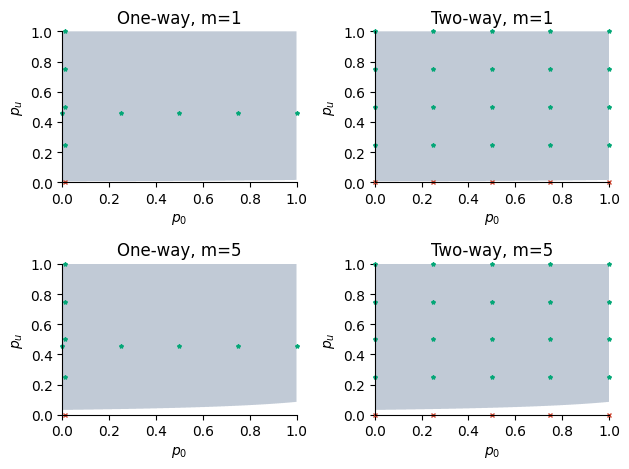

In [49]:
PlotGrid(2, 2, *plots)